# Football Prediction - Model Training
# Training and evaluating prediction models

# # Football Match Outcome Prediction - Model Training
# 
# This notebook trains multiple models to predict match outcomes:
# - Logistic Regression (baseline)
# - Random Forest
# - XGBoost
# - Model comparison and evaluation

In [1]:
# %% Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             f1_score, precision_score, recall_score, roc_auc_score)
import xgboost as xgb

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


In [2]:
# %% Cell 2: Load Engineered Features
features_df = pd.read_csv('../data/processed/features_engineered.csv')

print(f"✓ Loaded {len(features_df)} matches with features")
print(f"Date range: {features_df['fixture_date'].min()} to {features_df['fixture_date'].max()}")
print(f"\nOutcome distribution:")
print(features_df['outcome'].value_counts())

features_df.head()

✓ Loaded 1085 matches with features
Date range: 2021-01-10 to 2024-12-05

Outcome distribution:
outcome
H    487
A    351
D    247
Name: count, dtype: int64


,match_id,fixture_date,league_id,season,home_team_id,away_team_id,outcome,outcome_numeric,home_form_points,home_form_wins,...,h2h_matches,h2h_home_wins,h2h_draws,h2h_away_wins,h2h_home_goals_avg,h2h_away_goals_avg,form_points_diff,form_ppg_diff,form_goals_scored_diff,form_goals_conceded_diff
0,94202101108,2021-01-10,94,2020,1008,1009,D,0,0,0,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
1,94202101105,2021-01-10,94,2020,1005,1007,A,2,0,0,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
2,942021011114,2021-01-11,94,2020,1014,1011,H,1,0,0,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
3,94202101119,2021-01-11,94,2020,1009,1010,D,0,1,0,...,0,0,0,0,0.0,0.0,1,1.0,0.0,0.0
4,942021021012,2021-02-10,94,2020,1012,1010,H,1,0,0,...,0,0,0,0,0.0,0.0,-1,-1.0,-1.0,1.0


In [3]:
# %% Cell 3: Prepare Training Data

# Define feature columns (exclude ID, date, and target columns)
exclude_cols = ['match_id', 'fixture_date', 'league_id', 'season', 
                'home_team_id', 'away_team_id', 'outcome', 'outcome_numeric']

feature_columns = [col for col in features_df.columns if col not in exclude_cols]

print(f"Total features for training: {len(feature_columns)}")
print(f"\nFeature list:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feat}")

# Prepare X (features) and y (target)
X = features_df[feature_columns]
y = features_df['outcome']  # H, D, A

# Check for any missing values
if X.isnull().sum().sum() > 0:
    print("\n⚠️ Warning: Missing values detected. Filling with 0...")
    X = X.fillna(0)
else:
    print("\n✓ No missing values in features")

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Total features for training: 32

Feature list:
   1. home_form_points
   2. home_form_wins
   3. home_form_draws
   4. home_form_losses
   5. home_form_goals_scored
   6. home_form_goals_conceded
   7. home_form_avg_goals_scored
   8. home_form_avg_goals_conceded
   9. home_form_win_rate
  10. home_form_ppg
  11. away_form_points
  12. away_form_wins
  13. away_form_draws
  14. away_form_losses
  15. away_form_goals_scored
  16. away_form_goals_conceded
  17. away_form_avg_goals_scored
  18. away_form_avg_goals_conceded
  19. away_form_win_rate
  20. away_form_ppg
  21. home_home_points_last_5
  22. away_away_points_last_5
  23. h2h_matches
  24. h2h_home_wins
  25. h2h_draws
  26. h2h_away_wins
  27. h2h_home_goals_avg
  28. h2h_away_goals_avg
  29. form_points_diff
  30. form_ppg_diff
  31. form_goals_scored_diff
  32. form_goals_conceded_diff

✓ No missing values in features

Feature matrix shape: (1085, 32)
Target distribution:
outcome
H    487
A    351
D    247
Name: count, dtype:

In [4]:
# %% Cell 4: Train-Test Split

# Use temporal split (train on older data, test on recent data)
# This is more realistic for time-series prediction

# Sort by date
features_df_sorted = features_df.sort_values('fixture_date')
split_idx = int(len(features_df_sorted) * 0.8)  # 80% train, 20% test

train_df = features_df_sorted.iloc[:split_idx]
test_df = features_df_sorted.iloc[split_idx:]

X_train = train_df[feature_columns].fillna(0)
y_train = train_df['outcome']
X_test = test_df[feature_columns].fillna(0)
y_test = test_df['outcome']

print("="*60)
print("TRAIN-TEST SPLIT (Temporal)")
print("="*60)
print(f"Training set: {len(X_train)} matches")
print(f"  Date range: {train_df['fixture_date'].min()} to {train_df['fixture_date'].max()}")
print(f"  Outcome distribution:\n{y_train.value_counts()}")

print(f"\nTest set: {len(X_test)} matches")
print(f"  Date range: {test_df['fixture_date'].min()} to {test_df['fixture_date'].max()}")
print(f"  Outcome distribution:\n{y_test.value_counts()}")

TRAIN-TEST SPLIT (Temporal)
Training set: 868 matches
  Date range: 2021-01-10 to 2023-11-02
  Outcome distribution:
outcome
H    389
A    285
D    194
Name: count, dtype: int64

Test set: 217 matches
  Date range: 2023-11-02 to 2024-12-05
  Outcome distribution:
outcome
H    98
A    66
D    53
Name: count, dtype: int64


In [5]:
# %% Cell 5: Feature Scaling

# Standardize features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")


✓ Features scaled using StandardScaler



MODEL 1: LOGISTIC REGRESSION (Baseline)

Accuracy: 0.4654 (46.54%)
F1-Score (weighted): 0.3867

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.47      0.33      0.39        66
        Draw       0.00      0.00      0.00        53
    Home Win       0.47      0.81      0.59        98

    accuracy                           0.47       217
   macro avg       0.31      0.38      0.33       217
weighted avg       0.35      0.47      0.39       217



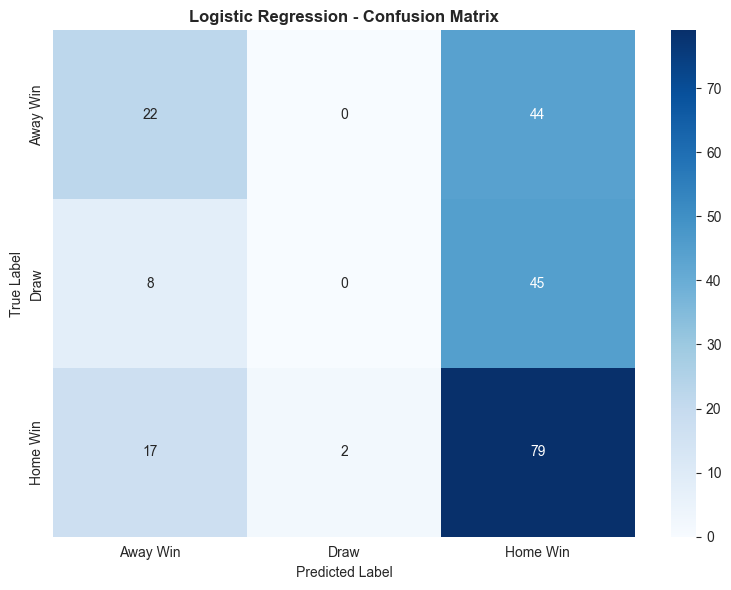

In [6]:
# %% Cell 6: Model 1 - Logistic Regression (Baseline)

print("\n" + "="*60)
print("MODEL 1: LOGISTIC REGRESSION (Baseline)")
print("="*60)

lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_lr_proba = lr_model.predict_proba(X_test_scaled)

# Evaluation
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\nAccuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"F1-Score (weighted): {lr_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Away Win', 'Draw', 'Home Win']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=['A', 'D', 'H'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.title('Logistic Regression - Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


MODEL 2: RANDOM FOREST

Accuracy: 0.4009 (40.09%)
F1-Score (weighted): 0.3489

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.32      0.35      0.33        66
        Draw       0.20      0.02      0.03        53
    Home Win       0.45      0.64      0.53        98

    accuracy                           0.40       217
   macro avg       0.32      0.34      0.30       217
weighted avg       0.35      0.40      0.35       217



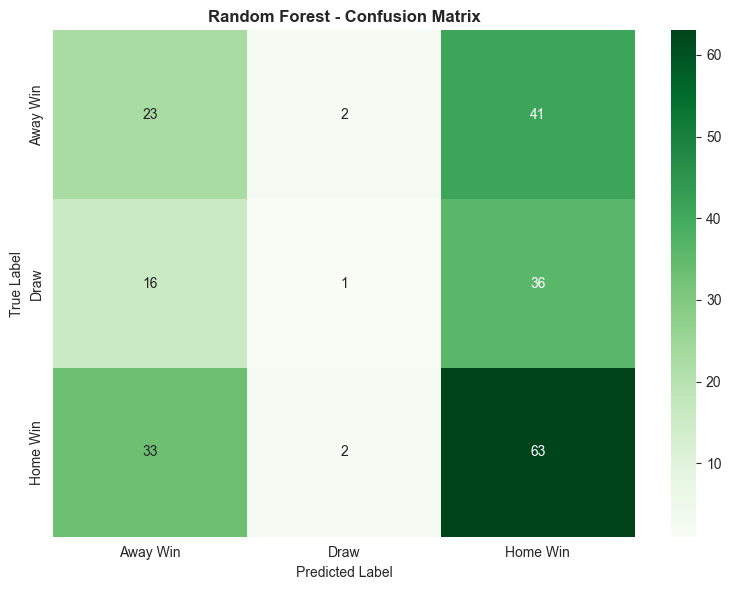

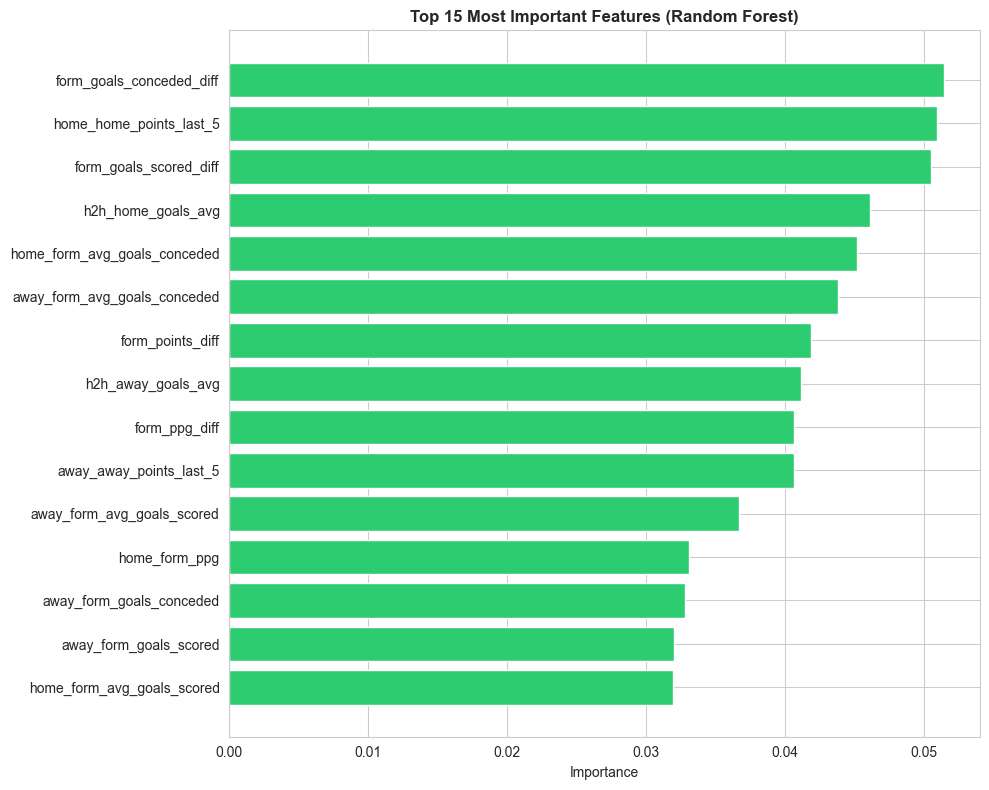


Top 10 Most Important Features:
                     feature  importance
    form_goals_conceded_diff    0.051488
     home_home_points_last_5    0.050965
      form_goals_scored_diff    0.050513
          h2h_home_goals_avg    0.046151
home_form_avg_goals_conceded    0.045222
away_form_avg_goals_conceded    0.043861
            form_points_diff    0.041917
          h2h_away_goals_avg    0.041168
               form_ppg_diff    0.040696
     away_away_points_last_5    0.040665


In [7]:
# %% Cell 7: Model 2 - Random Forest

print("\n" + "="*60)
print("MODEL 2: RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_proba = rf_model.predict_proba(X_test)

# Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\nAccuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"F1-Score (weighted): {rf_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Away Win', 'Draw', 'Home Win']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=['A', 'D', 'H'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.title('Random Forest - Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_n = 15
plt.barh(range(top_n), feature_importance['importance'].head(top_n), color='#2ecc71')
plt.yticks(range(top_n), feature_importance['feature'].head(top_n))
plt.xlabel('Importance')
plt.title(f'Top {top_n} Most Important Features (Random Forest)', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))


MODEL 3: XGBOOST

Accuracy: 0.3502 (35.02%)
F1-Score (weighted): 0.3241

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.26      0.30      0.28        66
        Draw       0.27      0.08      0.12        53
    Home Win       0.41      0.53      0.46        98

    accuracy                           0.35       217
   macro avg       0.31      0.30      0.29       217
weighted avg       0.33      0.35      0.32       217



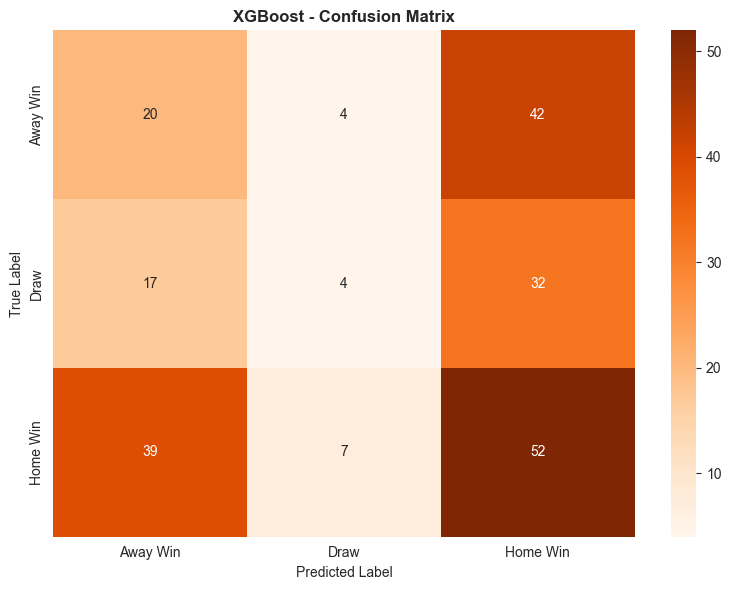

In [8]:
# %% Cell 8: Model 3 - XGBoost

print("\n" + "="*60)
print("MODEL 3: XGBOOST")
print("="*60)

# Map outcomes to numeric for XGBoost
outcome_map = {'A': 0, 'D': 1, 'H': 2}
y_train_numeric = y_train.map(outcome_map)
y_test_numeric = y_test.map(outcome_map)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train_numeric)

# Predictions
y_pred_xgb_numeric = xgb_model.predict(X_test)
y_pred_xgb_proba = xgb_model.predict_proba(X_test)

# Map back to outcomes
reverse_map = {0: 'A', 1: 'D', 2: 'H'}
y_pred_xgb = pd.Series(y_pred_xgb_numeric).map(reverse_map)

# Evaluation
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"\nAccuracy: {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print(f"F1-Score (weighted): {xgb_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Away Win', 'Draw', 'Home Win']))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=['A', 'D', 'H'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.title('XGBoost - Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


MODEL COMPARISON
              Model  Accuracy  F1-Score
Logistic Regression  0.465438  0.386680
      Random Forest  0.400922  0.348894
            XGBoost  0.350230  0.324087


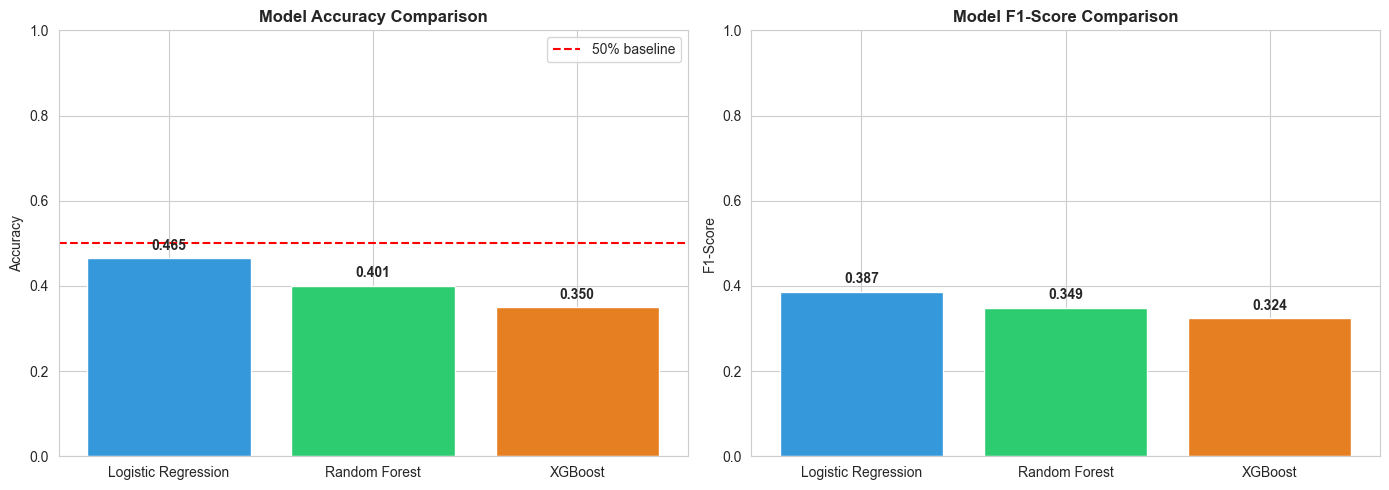


🏆 Best Model: Logistic Regression
   Accuracy: 0.4654 (46.54%)


In [9]:
# %% Cell 9: Model Comparison

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy],
    'F1-Score': [lr_f1, rf_f1, xgb_f1]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results.to_string(index=False))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax1.bar(results['Model'], results['Accuracy'], color=['#3498db', '#2ecc71', '#e67e22'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison', fontweight='bold')
ax1.set_ylim([0, 1])
ax1.axhline(y=0.5, color='r', linestyle='--', label='50% baseline')
ax1.legend()
for i, v in enumerate(results['Accuracy']):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1-Score comparison
ax2.bar(results['Model'], results['F1-Score'], color=['#3498db', '#2ecc71', '#e67e22'])
ax2.set_ylabel('F1-Score')
ax2.set_title('Model F1-Score Comparison', fontweight='bold')
ax2.set_ylim([0, 1])
for i, v in enumerate(results['F1-Score']):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Find best model
best_model_idx = results['Accuracy'].idxmax()
best_model_name = results.loc[best_model_idx, 'Model']
best_accuracy = results.loc[best_model_idx, 'Accuracy']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")


PER-CLASS PERFORMANCE (Best Model: Random Forest)
 Outcome  Precision   Recall  F1-Score  Support
Home Win   0.450000 0.642857  0.529412       98
    Draw   0.200000 0.018868  0.034483       53
Away Win   0.319444 0.348485  0.333333       66


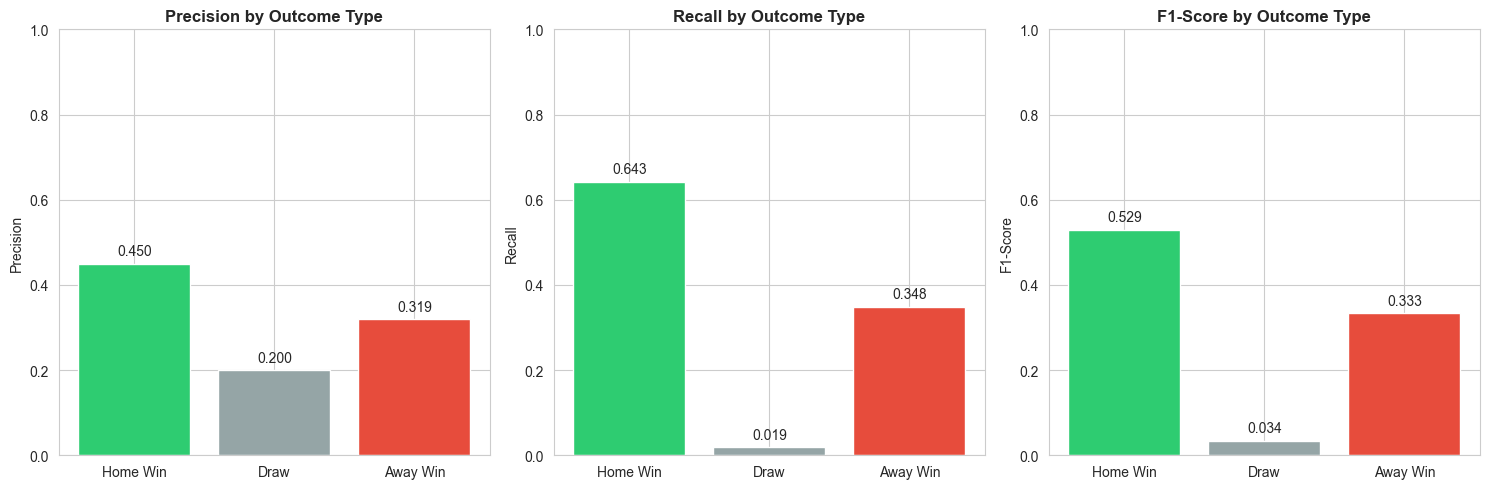

In [10]:
# %% Cell 10: Per-Class Performance Analysis

# Analyze performance for each outcome type
print("\n" + "="*60)
print("PER-CLASS PERFORMANCE (Best Model: Random Forest)")
print("="*60)

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_rf, labels=['H', 'D', 'A']
)

class_performance = pd.DataFrame({
    'Outcome': ['Home Win', 'Draw', 'Away Win'],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(class_performance.to_string(index=False))

# Visualize per-class performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Precision', 'Recall', 'F1-Score']
colors = ['#2ecc71', '#95a5a6', '#e74c3c']

for idx, metric in enumerate(metrics):
    axes[idx].bar(class_performance['Outcome'], class_performance[metric], color=colors)
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(f'{metric} by Outcome Type', fontweight='bold')
    axes[idx].set_ylim([0, 1])
    for i, v in enumerate(class_performance[metric]):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [11]:
# %% Cell 11: Cross-Validation

print("\n" + "="*60)
print("CROSS-VALIDATION (5-Fold)")
print("="*60)

# Use Random Forest for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"CV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


CROSS-VALIDATION (5-Fold)
CV Scores: [0.41474654 0.43778802 0.46082949 0.44700461 0.44700461]
Mean CV Accuracy: 0.4415 (+/- 0.0305)


In [12]:
# %% Cell 12: Save Best Model

# Save the best model (Random Forest)
best_model = rf_model
model_path = '../models/best_model_rf.pkl'
scaler_path = '../models/scaler.pkl'

# Create models directory if it doesn't exist
import os
os.makedirs('../models', exist_ok=True)

# Save model
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"\n✓ Saved best model to: {model_path}")
print(f"✓ Saved scaler to: {scaler_path}")

# Save feature names
feature_names_path = '../models/feature_names.txt'
with open(feature_names_path, 'w') as f:
    f.write('\n'.join(feature_columns))

print(f"✓ Saved feature names to: {feature_names_path}")


✓ Saved best model to: ../models/best_model_rf.pkl
✓ Saved scaler to: ../models/scaler.pkl
✓ Saved feature names to: ../models/feature_names.txt


In [13]:
# %% Cell 13: Prediction Examples

print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

# Get 5 random test samples
sample_indices = np.random.choice(test_df.index, 5, replace=False)

for idx in sample_indices:
    match = test_df.loc[idx]
    
    # Get features
    X_sample = match[feature_columns].values.reshape(1, -1)
    
    # Predict
    pred = rf_model.predict(X_sample)[0]
    pred_proba = rf_model.predict_proba(X_sample)[0]
    
    # Map probabilities to outcomes
    outcome_labels = rf_model.classes_
    proba_dict = dict(zip(outcome_labels, pred_proba))
    
    print(f"\nMatch: {match['fixture_date']}")
    print(f"  Home: Team {match['home_team_id']} | Away: Team {match['away_team_id']}")
    print(f"  Actual: {match['outcome']} | Predicted: {pred}")
    print(f"  Probabilities:")
    print(f"    Home Win: {proba_dict.get('H', 0):.2%}")
    print(f"    Draw: {proba_dict.get('D', 0):.2%}")
    print(f"    Away Win: {proba_dict.get('A', 0):.2%}")
    print(f"  Correct: {'✓' if pred == match['outcome'] else '✗'}")


SAMPLE PREDICTIONS

Match: 2023-11-02
  Home: Team 1016 | Away: Team 1019
  Actual: A | Predicted: H
  Probabilities:
    Home Win: 52.14%
    Draw: 19.69%
    Away Win: 28.18%
  Correct: ✗

Match: 2024-09-03
  Home: Team 1019 | Away: Team 1009
  Actual: H | Predicted: A
  Probabilities:
    Home Win: 27.66%
    Draw: 24.51%
    Away Win: 47.82%
  Correct: ✗

Match: 2023-12-08
  Home: Team 1009 | Away: Team 1012
  Actual: H | Predicted: H
  Probabilities:
    Home Win: 54.77%
    Draw: 13.22%
    Away Win: 32.02%
  Correct: ✓

Match: 2024-10-02
  Home: Team 1011 | Away: Team 1016
  Actual: A | Predicted: A
  Probabilities:
    Home Win: 40.14%
    Draw: 11.62%
    Away Win: 48.23%
  Correct: ✓

Match: 2024-11-03
  Home: Team 1009 | Away: Team 1004
  Actual: D | Predicted: A
  Probabilities:
    Home Win: 36.99%
    Draw: 12.36%
    Away Win: 50.65%
  Correct: ✗


In [14]:
# %% Cell 14: Summary

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nDataset:")
print(f"  Total matches: {len(features_df)}")
print(f"  Training: {len(X_train)}")
print(f"  Testing: {len(X_test)}")
print(f"  Features: {len(feature_columns)}")

print(f"\nBest Model: {best_model_name}")
print(f"  Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"  F1-Score: {results.loc[best_model_idx, 'F1-Score']:.4f}")

print(f"\nPer-Class Performance (Best Model):")
print(class_performance[['Outcome', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

print(f"\nModel saved to: {model_path}")
print(f"\n✓ Training complete!")


TRAINING SUMMARY

Dataset:
  Total matches: 1085
  Training: 868
  Testing: 217
  Features: 32

Best Model: Logistic Regression
  Accuracy: 0.4654 (46.54%)
  F1-Score: 0.3867

Per-Class Performance (Best Model):
 Outcome  Precision   Recall  F1-Score
Home Win   0.450000 0.642857  0.529412
    Draw   0.200000 0.018868  0.034483
Away Win   0.319444 0.348485  0.333333

Model saved to: ../models/best_model_rf.pkl

✓ Training complete!


In [15]:
# %% Cell 15: Key Insights

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

print(f"\n1. MODEL PERFORMANCE:")
print(f"   - Best accuracy: {best_accuracy*100:.2f}%")
if best_accuracy > 0.55:
    print(f"   - This beats random guessing (33%) and naive baseline (45%)")
else:
    print(f"   - This is close to baseline - may need more features or data")

print(f"\n2. HARDEST TO PREDICT:")
hardest_class = class_performance.loc[class_performance['F1-Score'].idxmin(), 'Outcome']
print(f"   - {hardest_class} is hardest to predict")
print(f"   - This is common in football - draws are notoriously difficult")

print(f"\n3. MOST IMPORTANT FEATURES:")
print(f"   Top 3:")
for i, row in feature_importance.head(3).iterrows():
    print(f"   {i+1}. {row['feature']}")

print(f"\n4. NEXT STEPS:")
print(f"   - Try hyperparameter tuning for better accuracy")
print(f"   - Add more features (player data, injuries, weather)")
print(f"   - Collect more historical data")
print(f"   - Test on live matches!")

print("\n" + "="*60)


KEY INSIGHTS

1. MODEL PERFORMANCE:
   - Best accuracy: 46.54%
   - This is close to baseline - may need more features or data

2. HARDEST TO PREDICT:
   - Draw is hardest to predict
   - This is common in football - draws are notoriously difficult

3. MOST IMPORTANT FEATURES:
   Top 3:
   32. form_goals_conceded_diff
   21. home_home_points_last_5
   31. form_goals_scored_diff

4. NEXT STEPS:
   - Try hyperparameter tuning for better accuracy
   - Add more features (player data, injuries, weather)
   - Collect more historical data
   - Test on live matches!

